In [1]:
! pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 114.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os


from scipy.special import erfc


In [9]:
def generate_bits(num_bits, seed=42):
    """Generate random bits."""
    np.random.seed(seed)
    return np.random.randint(0, 2, num_bits)

In [10]:
def bpsk_modulation(bits):
    """
    BPSK modulation: map bits to symbols
    0 -> -1, 1 -> +1
    """
    return 2 * bits - 1


In [11]:
def awgn_channel(symbols, SNR_dB):
    """
    Additive White Gaussian Noise channel

    Returns:
    --------
    received : array
        Noisy received symbols
    noise_power : float
        Noise power (needed for soft decision LLR calculation)
    """
    SNR_linear = 10 ** (SNR_dB / 10)
    noise_power = 1 / SNR_linear
    noise = np.random.normal(0, np.sqrt(noise_power), len(symbols))
    received = symbols + noise
    return received, noise_power

In [12]:
def hard_decision_demodulator(received_symbols):
    """
    Hard decision demodulator: threshold at 0
    Output: binary bits (0 or 1)
    """
    return (received_symbols > 0).astype(int)

In [13]:
def soft_decision_demodulator(received_symbols, noise_power):
    """
    Soft decision demodulator: compute Log-Likelihood Ratios

    LLR = log(P(bit=1|received) / P(bit=0|received))
    For BPSK over AWGN: LLR = (2 * received * A) / noise_power
    Where A = signal amplitude (1 for our case)

    Returns:
    --------
    llr : array
        Log-Likelihood Ratios (confidence values)
    """
    signal_amplitude = 1
    llr = (2 * received_symbols * signal_amplitude) / noise_power
    return llr

In [14]:
def calculate_ber(original_bits, decoded_bits):
    """Calculate Bit Error Rate"""
    errors = np.sum(original_bits != decoded_bits)
    ber = errors / len(original_bits)
    return ber, errors

In [15]:
def hamming_encode(data_bits):
    """
    Encode 4 data bits into 7 bits using Hamming(7,4) code

    Parameters:
    -----------
    data_bits : array
        Input data bits (length must be multiple of 4)

    Returns:
    --------
    encoded : array
        Encoded bits using Hamming(7,4) - length will be (len(data_bits)/4)*7
    """
    # Generator matrix for Hamming(7,4)
    # [I_4 | P] where I_4 is 4x4 identity, P is parity bits
    G = np.array([
        [1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]
    ])

    encoded = []
    for i in range(0, len(data_bits), 4):
        block = data_bits[i:i+4]
        if len(block) == 4:
            # Matrix multiplication modulo 2
            codeword = np.dot(block, G) % 2
            encoded.extend(codeword)

    return np.array(encoded)


In [16]:
def hamming_decode_hard(received_bits):
    """
    Decode Hamming(7,4) using HARD decisions (syndrome decoding)

    Parameters:
    -----------
    received_bits : array
        Hard-decision bits (0 or 1) from demodulator

    Returns:
    --------
    decoded : array
        Decoded data bits (4 bits for every 7 received bits)
    """
    # Parity check matrix for Hamming(7,4)
    H = np.array([
        [1, 1, 0, 1, 1, 0, 0],
        [1, 0, 1, 1, 0, 1, 0],
        [0, 1, 1, 1, 0, 0, 1]
    ])

    # Syndrome lookup table: syndrome -> error position
    # If syndrome is (0,0,0), no error
    syndrome_table = {
        (0, 0, 0): -1,   # No error
        (1, 1, 0): 0,    # Error in position 0
        (1, 0, 1): 1,    # Error in position 1
        (0, 1, 1): 2,    # Error in position 2
        (1, 1, 1): 3,    # Error in position 3
        (1, 0, 0): 4,    # Error in position 4
        (0, 1, 0): 5,    # Error in position 5
        (0, 0, 1): 6     # Error in position 6
    }

    decoded = []
    for i in range(0, len(received_bits), 7):
        block = received_bits[i:i+7]
        if len(block) == 7:
            # Step 1: Calculate syndrome
            syndrome = np.dot(H, block) % 2
            syndrome_tuple = tuple(syndrome)

            # Step 2: Correct error if detected
            corrected = block.copy()
            if syndrome_tuple in syndrome_table:
                error_pos = syndrome_table[syndrome_tuple]
                if error_pos >= 0:  # Error detected
                    corrected[error_pos] = 1 - corrected[error_pos]  # Flip bit

            # Step 3: Extract data bits (first 4 positions)
            decoded.extend(corrected[:4])

    return np.array(decoded)

In [17]:
def hamming_decode_soft_ml(llr_values):
    """
    OPTIMAL Maximum Likelihood soft decision decoder for Hamming(7,4)

    This achieves the full theoretical soft-decision gain by:
    1. Trying all 16 possible data bit combinations
    2. Calculating likelihood for each using LLRs
    3. Selecting the most likely codeword

    Computational complexity: O(2^k) = O(16) per block (acceptable for Hamming)
    """
    # Generator matrix for Hamming(7,4)
    G = np.array([
        [1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 0, 1, 0, 1],
        [0, 0, 1, 0, 0, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]
    ])

    decoded = []

    for i in range(0, len(llr_values), 7):
        llr_block = llr_values[i:i+7]

        if len(llr_block) == 7:
            best_data_bits = None
            best_metric = -np.inf  # Start with worst possible metric

            # Exhaustive search: try all 16 possible data combinations (2^4)
            for data_int in range(16):
                # Convert integer to 4-bit binary array
                # e.g., 5 -> [0, 1, 0, 1]
                data_bits = np.array([int(b) for b in format(data_int, '04b')])

                # Encode these 4 data bits to get 7-bit codeword
                codeword = np.dot(data_bits, G) % 2

                # Calculate log-likelihood metric for this codeword
                # For each bit position j:
                #   If codeword[j] = 1: add +LLR[j]
                #   If codeword[j] = 0: add -LLR[j]
                # This is equivalent to: sum(LLR[j] * (2*codeword[j] - 1))

                # Convert codeword to {-1, +1} representation
                codeword_bipolar = 2 * codeword - 1

                # Metric = dot product of LLRs with bipolar codeword
                metric = np.dot(llr_block, codeword_bipolar)

                # Keep track of the best codeword
                if metric > best_metric:
                    best_metric = metric
                    best_data_bits = data_bits

            # Append the decoded data bits
            decoded.extend(best_data_bits)

    return np.array(decoded)

In [27]:
filename = '105'  # Make sure this folder exists in Colab files
seconds_to_process = 10
snr_value = 4  # The noise level
print(f"Loading ECG data from {filename}...")

Loading ECG data from 105...


In [28]:
record = wfdb.rdrecord(filename, sampto=360*seconds_to_process)
original_signal = record.p_signal[:, 0] # Get the first channel


sig_min = np.min(original_signal)
sig_max = np.max(original_signal)
signal_norm = (original_signal - sig_min) / (sig_max - sig_min)

signal_int = np.round(signal_norm * 255).astype(int)

In [29]:
bit_string = ""
for sample in signal_int:
    # Convert number to 8-bit binary string like '01010101'
    bit_string += format(sample, '08b')

# Turn string into numpy array of integers
tx_bits = np.array([int(b) for b in bit_string])

print(f"Data loaded. Signal length: {len(original_signal)}")
print(f"Total bits to transmit: {len(tx_bits)}")

Data loaded. Signal length: 3600
Total bits to transmit: 28800


In [30]:
pad_amount = (4 - len(tx_bits) % 4) % 4
if pad_amount > 0:
    padding = np.zeros(pad_amount, dtype=int)
    tx_bits_padded = np.concatenate([tx_bits, padding])
else:
    tx_bits_padded = tx_bits

Simulating transmission at 4dB...
Hard Decision Error: 0.2028
Soft Decision Error: 0.1316


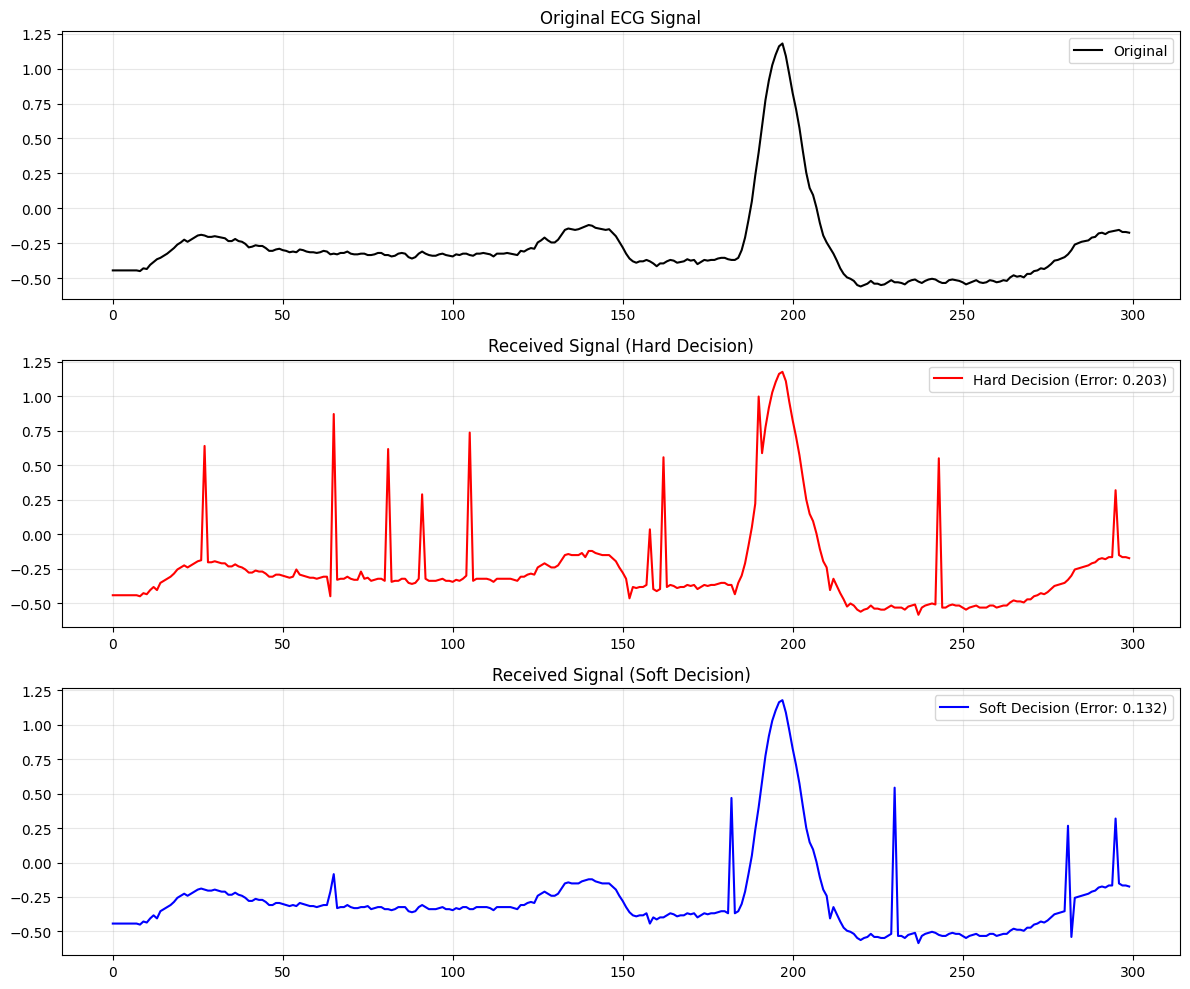

In [31]:
print(f"Simulating transmission at {snr_value}dB...")

# -- Transmitter --
encoded_bits = hamming_encode(tx_bits_padded)
transmitted_symbols = bpsk_modulation(encoded_bits)

# -- Channel --
received_signal, noise_pwr = awgn_channel(transmitted_symbols, snr_value)

# -- Receiver (Hard) --
hard_bits = hard_decision_demodulator(received_signal)
decoded_hard_bits = hamming_decode_hard(hard_bits)

# -- Receiver (Soft) --
llr_values = soft_decision_demodulator(received_signal, noise_pwr)
decoded_soft_bits = hamming_decode_soft_ml(llr_values)

# -- Cleanup (Remove Padding) --
if pad_amount > 0:
    decoded_hard_bits = decoded_hard_bits[:-pad_amount]
    decoded_soft_bits = decoded_soft_bits[:-pad_amount]

# ==========================================
# PART 4: RECONSTRUCTION & RESULTS
# ==========================================

def reconstruct_signal(bits, min_val, max_val):
    # Turn bits back into bytes
    # Reshape array into (Number of samples, 8 bits)
    bytes_array = bits.reshape(-1, 8)

    # Convert binary to integer
    # We multiply each bit by its power of 2 (128, 64, 32...)
    powers = np.array([128, 64, 32, 16, 8, 4, 2, 1])
    integers = bytes_array.dot(powers)

    # Convert back to original voltage scale
    reconstructed = (integers / 255.0) * (max_val - min_val) + min_val
    return reconstructed

# Reconstruct both signals
signal_hard = reconstruct_signal(decoded_hard_bits, sig_min, sig_max)
signal_soft = reconstruct_signal(decoded_soft_bits, sig_min, sig_max)

# Calculate Error (RMSE)
error_hard = np.sqrt(np.mean((original_signal - signal_hard)**2))
error_soft = np.sqrt(np.mean((original_signal - signal_soft)**2))

print(f"Hard Decision Error: {error_hard:.4f}")
print(f"Soft Decision Error: {error_soft:.4f}")

# Plotting
plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(original_signal[:300], 'k', label='Original')
plt.title("Original ECG Signal")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(signal_hard[:300], 'r', label=f'Hard Decision (Error: {error_hard:.3f})')
plt.title("Received Signal (Hard Decision)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(signal_soft[:300], 'b', label=f'Soft Decision (Error: {error_soft:.3f})')
plt.title("Received Signal (Soft Decision)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Starting Simulation Sweep...
SNR 0dB -> Hard Error: 0.4440 | Soft Error: 0.3786
SNR 1dB -> Hard Error: 0.3803 | Soft Error: 0.3129
SNR 2dB -> Hard Error: 0.3406 | Soft Error: 0.2661
SNR 3dB -> Hard Error: 0.2546 | Soft Error: 0.1787
SNR 4dB -> Hard Error: 0.1724 | Soft Error: 0.1218
SNR 5dB -> Hard Error: 0.1336 | Soft Error: 0.0669
SNR 6dB -> Hard Error: 0.0796 | Soft Error: 0.0317
SNR 7dB -> Hard Error: 0.0338 | Soft Error: 0.0030
SNR 8dB -> Hard Error: 0.0102 | Soft Error: 0.0022
SNR 9dB -> Hard Error: 0.0022 | Soft Error: 0.0022
SNR 10dB -> Hard Error: 0.0022 | Soft Error: 0.0022


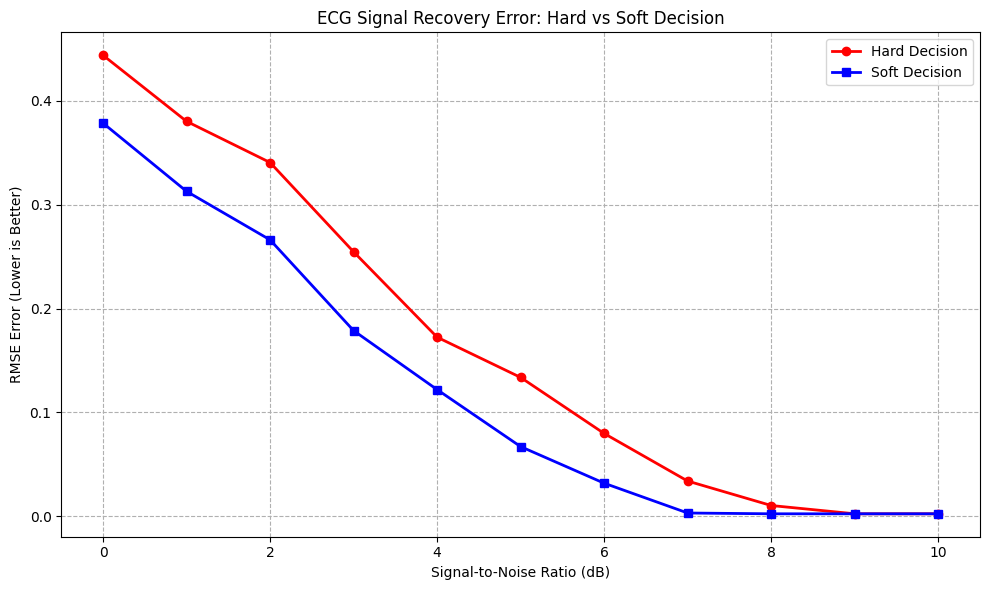


Done! The graph above proves that Soft Decision decoding provides lower error rates.


In [32]:
def reconstruct_signal(bits, min_val, max_val):
    bytes_array = bits.reshape(-1, 8)
    powers = np.array([128, 64, 32, 16, 8, 4, 2, 1])
    integers = bytes_array.dot(powers)
    reconstructed = (integers / 255.0) * (max_val - min_val) + min_val
    return reconstructed

# Define the range of noise levels to test (0dB to 10dB)
snr_range = range(0, 11)

# Lists to save our results for plotting
hard_errors = []
soft_errors = []

print("\nStarting Simulation Sweep...")

for snr in snr_range:
    # -- Channel --
    # Add new noise for this specific SNR level
    received_signal, noise_pwr = awgn_channel(transmitted_symbols, snr)

    # -- Receiver (Hard Decision) --
    hard_bits_raw = hard_decision_demodulator(received_signal)
    decoded_hard = hamming_decode_hard(hard_bits_raw)

    # -- Receiver (Soft Decision) --
    llr_values = soft_decision_demodulator(received_signal, noise_pwr)
    decoded_soft = hamming_decode_soft_ml(llr_values)

    # -- Remove Padding --
    if pad_amount > 0:
        decoded_hard = decoded_hard[:-pad_amount]
        decoded_soft = decoded_soft[:-pad_amount]

    # -- Reconstruct Signals --
    # We assume the lengths match the original signal
    sig_hard = reconstruct_signal(decoded_hard, sig_min, sig_max)
    sig_soft = reconstruct_signal(decoded_soft, sig_min, sig_max)

    # -- Calculate Error (RMSE) --
    # Compare the noisy reconstructed signal against the clean original
    err_hard = np.sqrt(np.mean((original_signal - sig_hard)**2))
    err_soft = np.sqrt(np.mean((original_signal - sig_soft)**2))

    # Save results
    hard_errors.append(err_hard)
    soft_errors.append(err_soft)

    print(f"SNR {snr}dB -> Hard Error: {err_hard:.4f} | Soft Error: {err_soft:.4f}")


# ==========================================
# PART 4: FINAL PLOT (The Result)
# ==========================================

plt.figure(figsize=(10, 6))

# Plot Hard Decision line
plt.plot(snr_range, hard_errors, 'r-o', label='Hard Decision', linewidth=2)

# Plot Soft Decision line
plt.plot(snr_range, soft_errors, 'b-s', label='Soft Decision', linewidth=2)

plt.title("ECG Signal Recovery Error: Hard vs Soft Decision")
plt.xlabel("Signal-to-Noise Ratio (dB)")
plt.ylabel("RMSE Error (Lower is Better)")
plt.grid(True, which="both", linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

print("\nDone! The graph above proves that Soft Decision decoding provides lower error rates.")